In [1]:
# Restructure of program into functions 
    # Data structures for scrape/request log and support/resistance (predicted vs actual)
    # L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
        # Timestamp issue for 15m chart  
# One hot encoding into function       
# Function to reshape data into LSTM/GRU input shape             
# Further reshaping of input/test data for LSTM/GRU model 

In [1]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

# API-specific imports (local install)
import gdax
    # Python setup.py install with environment activaated to install/use
    # Do not use default gdax pip install package - that version of the package is currently broken

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras import backend as K

# autoSR() import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

###########################################################################
### Force Keras/TF to use CPU backend when GPU present by setting:
    # {'CPU' : 1, 'GPU' : 0}
    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16288049865659812329
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9222031934
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13336782172314486406
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
# Request log load
request_log_df= pd.read_csv("test_data/request_log.csv",dtype ={'epoch':object})
request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]
print(request_start)
print(request_end)

2018-04-17T00:55:03.354Z
2018-04-17T01:05:03.469Z


In [3]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
#firstUpdate = False
firstUpdate_bids = False
firstUpdate_asks = False

# Value to track if feature_creation_inital() was run
feature_creation_intital_run = False

In [4]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [5]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        db['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
    scrape_time = 600

    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)
   

In [6]:
# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot  response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format for one-hot encoding
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
    save_csv()
    
def save_csv():
    
    # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)
    subscriptions.to_csv("raw_data/subscriptions.csv",header=True,encoding='utf-8',index =False)

In [7]:
# Function to read in data from csv into dataframes
    # Currently not working due to variable scope assignment for dataframes/reading in data from CSV

# Test data
#def data_read_test():
    
    # Read in test data for L2 orderbook state (bids + asks)
    # Read in test data for subsquent L2 orderbook update states (L2 updates to bid + asks)
    #snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    #snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    #l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'size':float})
    #request_log_df= pd.read_csv("test_data/request_log.csv")
    

    
    # Convert size column to float type for l2 updates
    #l2update_df['size'] = l2update_df['size'].apply(pd.to_numeric)
    #snapshot_bids_df['size_delta'] = snapshot_bids_df['size_delta'].apply(pd.to_numeric)

# Raw data
#def data_read_raw():
    
    # Read in test data for L2 orderbook state (bids + asks)
    # Read in test data for subsquent L2 orderbook update states (L2 updates to bid + asks)
    #snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    #snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    #l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
    #request_log_df= pd.read_csv("raw_data/request_log.csv")
    
    # Convert size column to float type for l2 updates
    #l2update_df['size'] = l2update_df['size'].apply(pd.to_numeric)
    #snapshot_bids_df['size_delta'] = snapshot_bids_df['size_delta'].apply(pd.to_numeric)

In [8]:
###########################################################################

# Section to read in data from csv (definition scope of functions above not working for assignment:)
    # Load in test data for development/debugging

snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'size':float})
request_log_df= pd.read_csv("test_data/request_log.csv")

###########################################################################

In [9]:
##### Request 15minute chart data #####

#def chart_15m_request(request_log_df):

request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]

# Request 15 minutes of candlestick (open high low close) data from API
    # start time must be in ISO 8601 format for get_product_historic_rates()
chart_15m = public_client.get_product_historic_rates('BTC-USD', start =request_start, granularity=60)

# Convert chart data response into dataframes
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

# Reorder columns according to label order required by matplotlib finance package
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

# Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
chart_15m_df.sort_values(by='time',axis=0, inplace =True)

#Convert/sort time to datetime object (for matplotlib chart format requirement)
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')
    
    

In [10]:
# Auto support/resistance adapted into function 
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
            
    return ml_results

In [11]:
def generate_chart(dataframe):
    
    dataframe = chart_15m_df 
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    fig, ax = plt.subplots(figsize=(20, 10)
                         )
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper labe set at 20,18 chart size
        # 15 + 2 =17
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-5), max(chart_15m_df['high'])+10, 5))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
    # Add S/R labels to right side of chart
    ml_results = autoSR(chart_15m_df)
    for k in ml_results:
        plt.axhline(y=k)

    #plt.tight_layout()
    return plt.show()
    #return plt.show(), ml_results

In [12]:
# create and set inital/placeholder values for size_delta, position, and sr_prox_value/line input features 
    # run once upon new scrape only
def feature_creation_inital():
    #global feature_creation_intital_run
    
    #if feature_creation_inital_run() == False:
        #global feature_creation_intital_run
        
        
        
    # Set inital size delta l2 snapshot - use decimal point to force as float
    snapshot_asks_df['size_delta'] = 0.0
    snapshot_bids_df['size_delta'] = 0.0

    # Set inital position for l2 snapshot
    snapshot_asks_df['position'] = snapshot_asks_df.index +1
    snapshot_bids_df['position'] = snapshot_bids_df.index +1

    # Reverse index for sell/asks
    # snapshot_asks_df =snapshot_asks_df[::-1]
    # Reverse inital position indicator for bids/buy side
    rev = snapshot_bids_df['position'].values * -1
    snapshot_bids_df['position'] = rev

    # Set inital proximity value and inital value for nearest prox line
    snapshot_asks_df['sr_prox_value'] = 0
    snapshot_asks_df['sr_prox_line'] = 0
    snapshot_bids_df['sr_prox_value'] = 0
    snapshot_bids_df['sr_prox_line'] = 0

    # Set feature_creation_inital_run flag to True once run
    feature_creation_inital_run = True
        
        
        
    #elif feature_creation_inital_run == True:
        #global feature_creation_intital_run
        # Required syntax for logical operator/ if-else structure, but does nothing as a result
        # i.e., a "pass"
        
        #print("pass")
        #pass
        

In [13]:
# L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
    # Applied to both snapshot_bids_df and snapshot_asks_df
    # Must be run before sr_update()
def l2_state_update():
    
    global firstUpdate_bids 
    global firstUpdate_asks
    
    for i in range(len(snapshot_bids_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_bids_df['price'].values[i])
            snapshot_bids_df.drop(snapshot_bids_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_bids == False:
            snapshot_bids_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_bids = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_bids_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_bids_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for bids snapshot
        snapshot_bids_df['position'] = snapshot_bids_df.index + 1
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev 

    for i in range(len(snapshot_asks_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_asks_df['price'].values[i])
            snapshot_asks_df.drop(snapshot_asks_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_asks == False:
            snapshot_asks_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_asks = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_asks_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_asks_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for_asks snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index + 1
        #rev = snapshot_asks_df['position'].values * -1
        #snapshot_asks_df['position'] = rev 

In [14]:
# Function to update sr_prox_line and sr_prox_value between orderbook states
    # Note: l2_state_update applied first, then sr_update(); switch order if linear calls or switch execution block cell
    # Must be run before model input in sequence
def sr_update():
    
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)

    ### snapshot_asks sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_asks_df['price'])):
        #if snapshot_asks_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_asks_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_asks_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_asks_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_asks_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

    ### snapshot_bids sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_bids_df['price'])):
        #if snapshot_bids_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_bids_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_bids_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_bids_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_bids_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

In [15]:
###########################################################################
###########################################################################
###########################################################################


# Debugging:

In [16]:
# Assignment of ml_results from function:
ml_results = autoSR(chart_15m_df)
autoSR(chart_15m_df)

[8815.0,
 8832.81,
 8840.86,
 8849.99,
 8851.8,
 8862.34,
 8870.03,
 8873.0,
 8880.79,
 8885.01,
 8895.36,
 8899.98,
 8905.01,
 8906.01,
 8909.99,
 8919.98,
 8928.19,
 8928.99,
 8935.0,
 8936.9,
 8939.0]

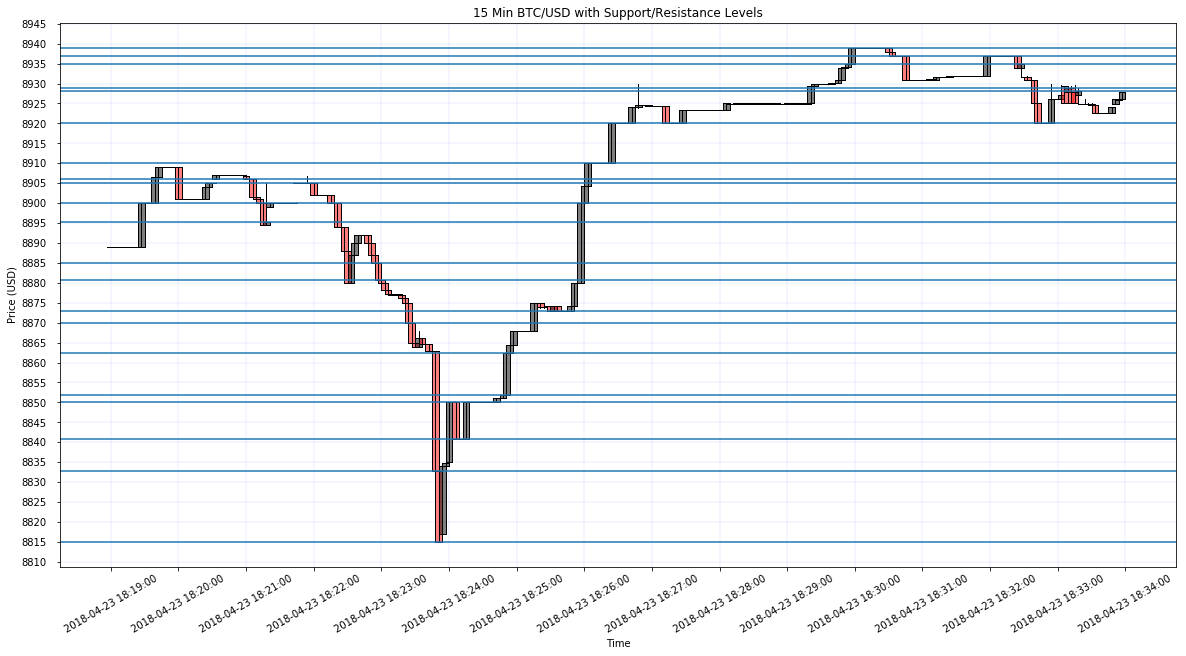

In [17]:
generate_chart(chart_15m_df)

In [18]:
# Data structures for scrape/request log and support/resistance (predicted vs actual)
    # request start, request end
    # current s/r levels: chart 15m data + ml_results (actual)
    # predicted s/r levels: ml_results (predicted)
    # current s/r levels vs predicted for current timeframe (training vs testing)

# Convert ml_results into sorted int array
ml_results_modified =np.asarray(ml_results)
ml_results_modified =np.trunc(ml_results_modified).astype(int)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 

In [19]:
snapshot_asks_df.head()

,side,price,size
0,sell,8042.91,10.656147
1,sell,8042.92,0.001181
2,sell,8042.93,0.001305
3,sell,8042.94,0.001181
4,sell,8042.95,1.265966


In [20]:
feature_creation_inital()

In [21]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.0,1,0,0
1,sell,8042.92,0.001181,0.0,2,0,0
2,sell,8042.93,0.001305,0.0,3,0,0
3,sell,8042.94,0.001181,0.0,4,0,0
4,sell,8042.95,1.265966,0.0,5,0,0


In [22]:
l2_state_update()

In [23]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.000,1,0,0
1,sell,8042.92,0.001181,0.020,2,0,0
2,sell,8042.93,0.001305,0.000,3,0,0
3,sell,8042.94,0.001181,0.001,4,0,0
4,sell,8042.95,1.265966,0.000,5,0,0


In [24]:
sr_update()

In [25]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.000,1,773,8815
1,sell,8042.92,0.001181,0.020,2,773,8815
2,sell,8042.93,0.001305,0.000,3,773,8815
3,sell,8042.94,0.001181,0.001,4,773,8815
4,sell,8042.95,1.265966,0.000,5,773,8815


In [ ]:
###########################################################################

# Inital snapshot state ---> First L2 updates + features applied = First complete state to feed into model
    # state 0: [price,size,size_delta,position,sr_prox_value,sr_prox_line]
        # State 0 = 15 minutes of data as unit
    # ml_results_modified is y value

In [26]:
# Results for predicted S/R levels may vary in total element/array length
    # But will still be array similar in shape to the below
ml_results_modified

array([8815, 8832, 8840, 8849, 8851, 8862, 8870, 8873, 8880, 8885, 8895,
       8899, 8905, 8906, 8909, 8919, 8928, 8928, 8935, 8936, 8939])

In [27]:

# Information about snapshot_asks_df for input shape information
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.000,1,773,8815
1,sell,8042.92,0.001181,0.020,2,773,8815
2,sell,8042.93,0.001305,0.000,3,773,8815
3,sell,8042.94,0.001181,0.001,4,773,8815
4,sell,8042.95,1.265966,0.000,5,773,8815


In [61]:
data = snapshot_asks_df.values
X = data[:,1:6]
y = data[:,6:7]
y = np.ravel(y)
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
#onehot_encoder = OneHotEncoder(sparse=False)
encoded_y = encoded_y.reshape(len(encoded_y), 1)
onehot_y = onehot_encoder.fit_transform(encoded_y)

In [62]:
X

array([[8042.91, 10.65614728, 0.0, 1, 773],
       [8042.92, 0.00118097, 0.02, 2, 773],
       [8042.93, 0.00130538, 0.0, 3, 773],
       ...,
       [9987654321.0, 0.00104855, 2.0, 16995, 9987645382],
       [9999999998.0, 0.013999999999999999, 1.24231, 16996, 9999991059],
       [9999999999.0, 0.02839242, 0.00375, 16997, 9999991060]],
      dtype=object)

In [63]:
y

array([8815, 8815, 8815, ..., 8939, 8939, 8939], dtype=object)

In [64]:
encoded_y

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [19],
       [19],
       [19]], dtype=int64)

In [65]:
onehot_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [66]:
# Shape information for input shaping
print(data.shape)
print("Shape without side column :")
print(X.shape)
print(y.shape)
print(onehot_y.shape)

(16997, 7)
Shape without side column :
(16997, 5)
(16997,)
(16997, 20)


In [166]:
print(X.shape)
Xshapetest = np.reshape(X, (X.shape[0], 1, X.shape[1]))
print(Xshapetest.shape)

(16997, 5)
(16997, 1, 5)


In [167]:
print(onehot_y.shape)

(16997, 20)


In [207]:
from keras.layers import Embedding
# Model construction
max_features = 5
model = Sequential()
#model.add(Embedding(7, 2500))
    #https://keras.io/layers/embeddings/
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), dropout=0.1, recurrent_dropout=0.2))
    #input_shape(timesteps,features)
model.add(Dense(20, activation='relu'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 100)               42400     
_________________________________________________________________
dense_48 (Dense)             (None, 20)                2020      
Total params: 44,420
Trainable params: 44,420
Non-trainable params: 0
_________________________________________________________________


In [208]:
model.fit(
    Xshapetest,
    onehot_y, 
    epochs=100,
    shuffle=True,
    verbose=2,
    batch_size=2500 #validation_data=(X, onehot_y)
)

Epoch 1/100
 - 2s - loss: 12.1164 - acc: 0.0083
Epoch 2/100
 - 0s - loss: 8.5139 - acc: 0.0341
Epoch 3/100
 - 0s - loss: 4.5257 - acc: 0.0942
Epoch 4/100
 - 0s - loss: 2.7060 - acc: 0.3116
Epoch 5/100
 - 0s - loss: 1.8282 - acc: 0.5146
Epoch 6/100
 - 0s - loss: 1.3551 - acc: 0.6837
Epoch 7/100
 - 0s - loss: 1.0538 - acc: 0.7858
Epoch 8/100
 - 0s - loss: 0.8192 - acc: 0.8086
Epoch 9/100
 - 0s - loss: 0.6967 - acc: 0.8191
Epoch 10/100
 - 0s - loss: 0.6438 - acc: 0.8279
Epoch 11/100
 - 0s - loss: 0.6102 - acc: 0.8353
Epoch 12/100
 - 0s - loss: 0.5826 - acc: 0.8358
Epoch 13/100
 - 0s - loss: 0.5357 - acc: 0.8431
Epoch 14/100
 - 0s - loss: 0.5401 - acc: 0.8502
Epoch 15/100
 - 0s - loss: 0.5149 - acc: 0.8591
Epoch 16/100
 - 0s - loss: 0.5194 - acc: 0.8692
Epoch 17/100
 - 0s - loss: 0.5080 - acc: 0.8834
Epoch 18/100
 - 0s - loss: 0.5063 - acc: 0.8919
Epoch 19/100
 - 0s - loss: 0.4836 - acc: 0.8965
Epoch 20/100
 - 0s - loss: 0.4714 - acc: 0.9057
Epoch 21/100
 - 0s - loss: 0.4634 - acc: 0.9137


In [209]:
model_loss, model_accuracy=model.evaluate(Xshapetest, onehot_y)
print(f" Model - Loss: {model_loss}, Accuracy: {model_accuracy}")

16997/16997 [==============================] - 2s 128us/step
 Model - Loss: 0.253322956439215, Accuracy: 0.9842913455315644


In [210]:
model.predict(Xshapetest)


array([[0.20781216, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.20781216, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.20781216, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.4198638 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.4198638 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.4198638 ]], dtype=float32)

In [212]:
model.predict_classes(Xshapetest)

array([ 0,  0,  0, ..., 19, 19, 19], dtype=int64)

In [ ]:
# One hot encoding into function 


In [ ]:
# Function to reshape data into LSTM/GRU input shape 
